In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.relpath("./segment-anything"))
import segment_anything

Segment Anything custom imported


/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = None
dataset = None

In [3]:
%cd datasets/
from fine_tune.configs.climbing import *
%cd ..

assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 4157.70it/s]

/home/andrewhealey/sam-fine-tuning


In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

Selecting classes ['climbing-holds', 'floor', 'person']


In [6]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)
sam.predictor.model.prompt_encoder.cpu()

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [8]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [9]:
from fine_tune.common import SamDataset,SamBoxDataset, SamPointDataset, SamNextMaskDataset, SamEverythingDataset, RandomPointDataset, SamDummyMaskDataset, SamSemSegDataset, SamComboDataset, get_max_iou_masks

import torch

from torch.utils.data import ConcatDataset

# still using singleton args b/c I might switch away from predictor
args = [predictor]
dataset_makers = {
    "sem_seg": lambda ds: SamSemSegDataset(ds,*args),
    "box": lambda ds: SamBoxDataset(ds,*args),
    "point": lambda ds: SamPointDataset(ds,*args,points_per_mask=cfg.data.points_per_mask),
    "cls": lambda ds: SamMidasBinaryClassification(ds,*args),
    "dummy": lambda ds: SamDummyMaskDataset(ds,*args),
    "everything": lambda ds: SamEverythingDataset(ds,*args,points_per_side=cfg.data.points_per_side,top_k=None),
    "random": lambda ds: RandomPointDataset(ds,*args,points_per_img=cfg.data.points_per_img),
}

def prep_datasets(ds):
    datasets = []
    for task in cfg.data.tasks:
        datasets.append(dataset_makers[task](ds))
    return SamComboDataset(datasets,*args)

curr_dataset = prep_datasets(train_dataset)
valid_curr_dataset = prep_datasets(valid_dataset)

from torch.utils.data import random_split
if cfg.data.valid_prompts is not None:
    num_prompts = len(valid_curr_dataset)

    # split off prompts
    valid_curr_dataset,_ = random_split(valid_curr_dataset,[cfg.data.valid_prompts,num_prompts-cfg.data.valid_prompts])

  8%|▊         | 2/24 [00:00<00:01, 13.42it/s]

100%|██████████| 7/7 [00:00<00:00, 73769.17it/s]


In [10]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt
from fine_tune.prompts import make_refinement_prompt


In [40]:
from PIL import Image
import numpy as np
from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0
    for batch in tqdm(valid_curr_dataset):

        batch = SamDataset.to_device(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
            loss = losses["loss"]

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(low_res_masks,iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

            running_loss += loss.item()
            running_count += 1
    valid_loss = running_loss/running_count

    wandb.log({
        "valid_loss": valid_loss,
    })

    print(f"VALID - Loss: {valid_loss:.4f}")

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [41]:
run_grad = False
curr_dataset = valid_curr_dataset

In [42]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


In [43]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.total_steps:
    evaluate()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            #
            # WandB
            #
            
            loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
            loss = loss_dict["loss"]

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                pass

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1
            if not run_grad: continue
            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step(curr_iters)

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/200 [00:00<?, ?it/s]


IndexError: The shape of the mask [1, 3] at index 1 does not match the shape of the indexed tensor [1, 1] at index 1

In [ ]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
print(f"Run saved to {export_dir}")

from .fine_tune.export import export

export(export_dir,cfg,sam)

/home/andrewhealey/sam-fine-tuning/runs
Run number: 76
/home/andrewhealey/sam-fine-tuning


In [ ]:
evaluate()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:04<00:00, 46.20it/s]

VALID - Loss: 0.9374


In [ ]:
idx = -1

one mask
tensor([0], device='cuda:0') tensor(0, device='cuda:0')
Predicted IoU: 0.7886220216751099
Predicted class: climbing-holds


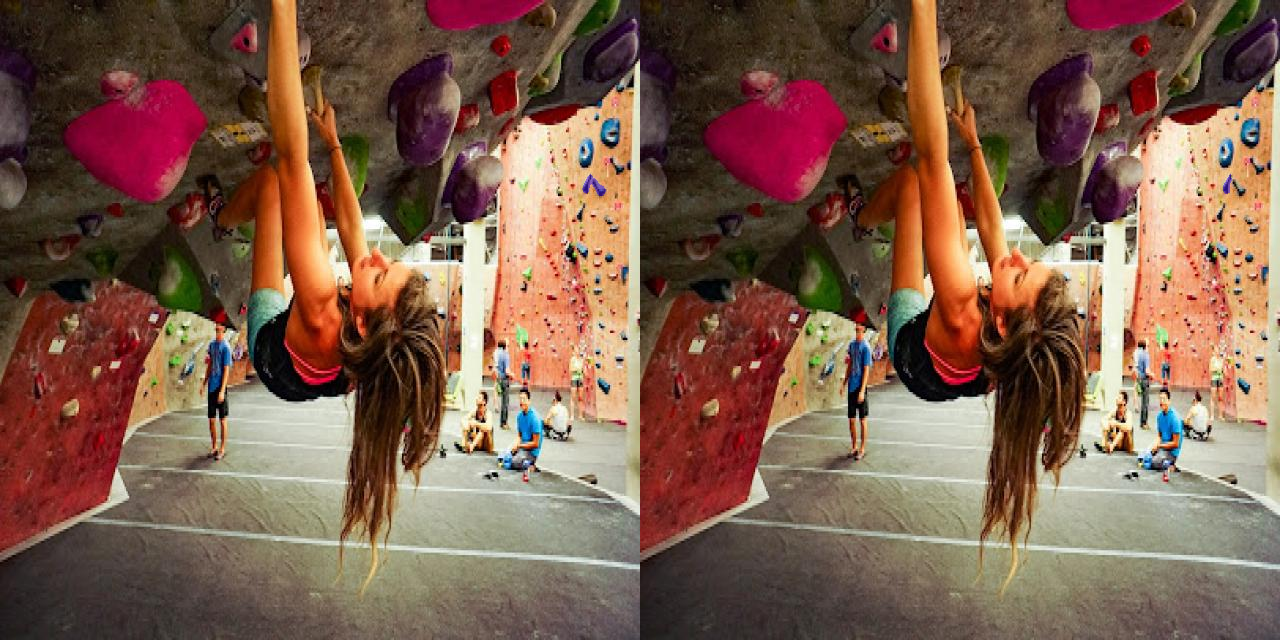

cls binary masks:


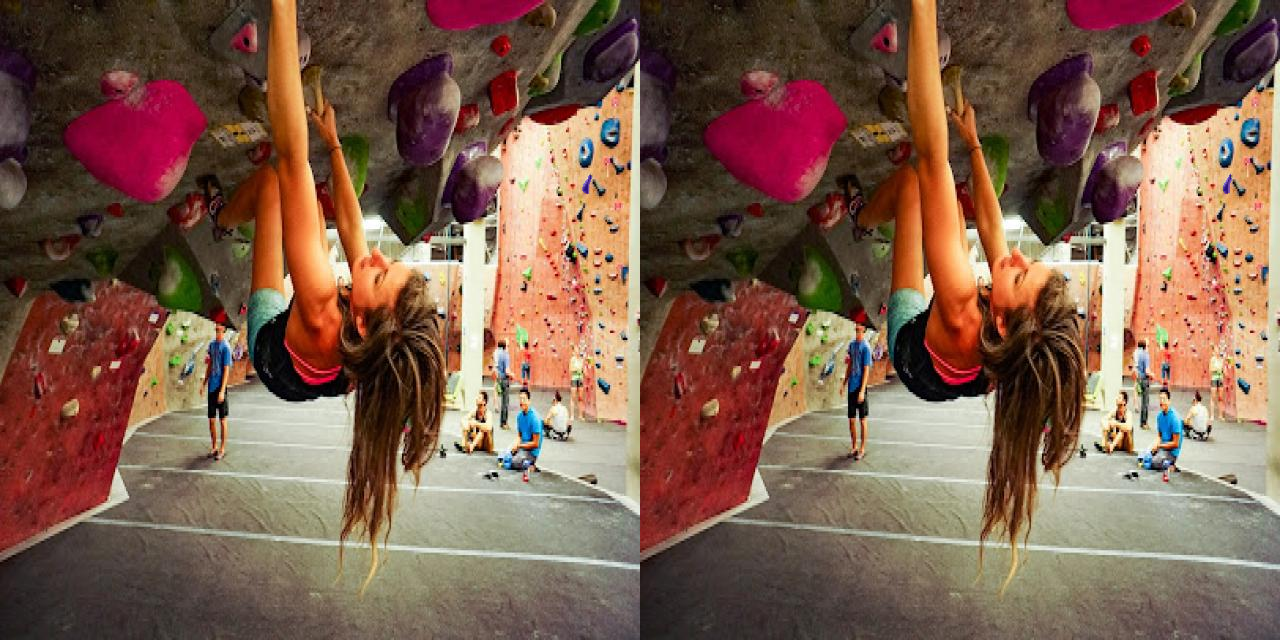

In [ ]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(v_c_ds[idx],device)

use_cls_tokens = cfg.model.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**new_input,**encoder_output)

        losses = decoder.loss(*pred,sizes,prompt)
        
        upscaled_masks,binary_masks,max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = iou_predictions[0,max_idx].item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, *_ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            cls_upscaled_masks,cls_binary_masks, pred_cls = decoder.postprocess_cls(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,_,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1




from PIL import Image
import numpy as np

# print cls loss
print("Cls loss:",losses["cls_loss"].item())
print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
print("Predicted cls IoU:",cls_iou_predictions[0,pred_cls].item(),"real cls IoU:",cls_iou_predictions[0,gt_cls].item())

print("binary masks:")
clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()
print("cls binary masks:")
clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

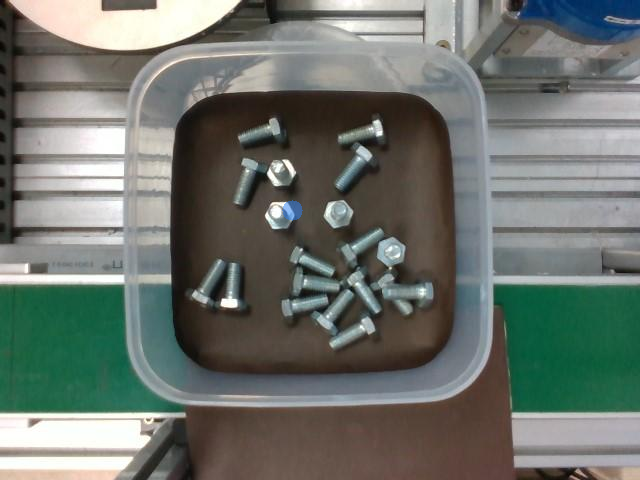

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)

# Predict on Test Set

# Segment Everything

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = predictor.model
# model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = list(valid_dataset.images.values())[0]
# img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.5,pred_iou_thresh=-0.6,points_per_side=64)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
iou_preds tensor(-0.5575, device='cuda:0')
iou_preds tensor(-0.5540, device='cuda:0')
iou_preds tensor(-0.5594, device='cuda:0')
iou_preds tensor(-0.5783, device='cuda:0')
iou_preds tensor(-0.6488, device='cuda:0')
iou_preds tensor(-0.6190, device='cuda:0')
iou_preds tensor(-0.6016, device='cuda:0')
iou_preds tensor(-0.5951, device='cuda:0')
iou_preds tensor(-0.5964, device='cuda:0')
iou_preds tensor(-0.5989, device='cuda:0')
iou_preds tensor(-0.6014, device='cuda:0')
iou_preds tensor(-0.6021, device='cuda:0')
iou_preds tensor(-0.5982, device='cuda:0')
iou_preds tensor(-0.5844, device='cuda:0')
iou_preds tensor(-0.5658, device='cuda:0')
iou_preds tensor(-0.5635, device='cuda:0')
iou_preds tensor(-0.5794, device='cuda:0')
iou_preds tensor(-0.6494, device='cuda:0')
iou_preds tensor(-0.6540, device='cuda:0')
iou_preds tensor(-0.6364, device='cuda:0')
iou_preds tensor(-0.6155, device='cuda:0')
iou_preds tensor(-0.6039, device='cuda:0')
iou_preds tensor(-0.

NotImplementedError: TODO: fix this

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

# Distance utils

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(train_dataset.images.keys()))

rand_img_dets = train_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances
    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map
empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))

# Progressive mask gen

In [ ]:
import supervision as sv

class LabellingSession:
    def __init__(self,img:np.ndarray):
        self.img = img
        self.sv_dataset = sv.DetectionDataset(
            classes=train_dataset.classes,
            images={
                "test":img
            },
            annotations={
                "test":sv.Detections.empty()
            }
        )
        self.torch_dataset = SamNextMaskDataset(self.sv_dataset,predictor,device)
        self.annotator = sv.MaskAnnotator()
    
    def update_detections(self,detections:sv.Detections):
        self.sv_dataset.annotations["test"] = detections

    def img_to_tensors(self):
        return self.torch_dataset[0]
    
    def show(self):
        return Image.fromarray(self.annotator.annotate(scene=self.img,detections=self.sv_dataset.annotations["test"]))
    
    @torch.no_grad()
    def get_next_mask(self):
        decoder_input, _, (input_size,original_size), img, (unresized_img,resized_img) = self.img_to_tensors()
        H,W,_ = img.shape

        new_input = {**decoder_input}

        if vit_lora:
            sam_embedding = image_encoder(resized_img)[0]
            new_input["image_embeddings"] = sam_embedding

        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]

            curr_embedding = new_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        assert len(iou_predictions.shape) == 1, f"IoU predictions shape is {iou_predictions.shape}"

        pred_idx = torch.argmax(iou_predictions)
        pred_mask = high_res_masks[pred_idx] > 0

        # new detection
        masks = pred_mask[None, :, :].cpu().numpy()
        class_id = 0
        new_dets = sv.Detections(
            xyxy=sv.Detections.mask_to_xyxy(masks),
            mask=masks,
            class_id=np.array([class_id]),
        )

        self.update_detections(new_dets)


In [ ]:
demo_img = cv2.imread("test.jpg")

session = LabellingSession(demo_img)

In [ ]:
session.get_next_mask()

session.show